### Import modules

In [1]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from itertools import groupby


sys.path.append("./Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb

In [2]:
dc = datacube.Datacube(app='WCF')

In [48]:
# Make sure to change the location for in the save file
location = 'Kakadu'
# min_x= 0
# max_x= 100000
# min_y= -1350000
# max_y= -1250000

min_x= 1149000
max_x= 1169000
min_y= -4783821
max_y= -4763000

x = (min_x, max_x)
y = (min_y, max_y)

res_x = 100
res_y = -100

start_date = '2015'
end_date = '2015' 

#Display an interactive map
display_map(x=x, y=y, crs='EPSG:3577', margin=-0.1) 

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

In [49]:
def wofs_fusefunc(dest, src):
    """
    Fuse two WOfS water measurements represented as `ndarray`s.
    """
    
    empty = (dest & 1).astype(np.bool)
    both = ~empty & ~((src & 1).astype(np.bool))
    dest[empty] = src[empty]
    dest[both] |= src[both]

In [50]:
# Load data
wofs_daily = dc.load(
              product=['wofs_albers'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y),
              #resolution=(-50, 50),
              group_by='solar_day',
              fuse_func=wofs_fusefunc
)


In [51]:
wofs_daily

<xarray.Dataset>
Dimensions:      (time: 32, x: 200, y: 209)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-10T23:51:12 ... 2015-12-28T23:53:58.500000
  * y            (y) float64 -4.784e+06 -4.784e+06 ... -4.763e+06 -4.763e+06
  * x            (x) float64 1.169e+06 1.169e+06 ... 1.149e+06 1.149e+06
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) int16 32 32 32 32 32 32 ... 231 231 231 231 231
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Implement new method (consectutive count)

In [52]:
## Define consecutive count   
def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
    :param float required_consecutive: how many consectutive 1's to be classified as water?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = max(counts)
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

In [53]:
from datacube.storage import masking

data = wofs_daily

data_nan = masking.mask_invalid_data(data)

# Select clear and water pixels - binary
water = ((data.water == 128) | (data.water == 132)).to_dataset()
clear = ((data.water == 128) | (data.water == 132) | (data.water == 0)).to_dataset()
print('Water',water)

# Group by month - total number of observations
water_month = water.groupby('time.month').sum(dim='time')   
clear_month = clear.groupby('time.month').sum(dim='time') 
clear_year = clear.groupby('time.year').sum(dim='time')   #just for testing

# Calculate frequency of water observations within the month
freq = water_month/clear_month

# Threshold frequency in month to get water or not
# Values greater than 0.5 kept
water_dominant = freq['water'] > 0.5
# Converted to binary
water_mask = water_dominant.where(freq['water'] >= 0)

# Make values of > 0.5 == 1 (end result in binary water mask)
# water_mask_drop = np.where(water_mask > 0.5, 1, water_mask)
water_mask_drop = np.where(freq['water'] > 0.5, 1, 0)
water_mask_xr = xr.DataArray(water_mask_drop, coords=water_mask.coords, dims=water_mask.dims)

# Pull tv as numpy array
water_numpy = water_mask_xr.values # equals water_mask_drop?
#print('NEW WATER PERSISTENCE',water_numpy)

# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 1

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((water_numpy.shape[1], water_numpy.shape[2]), dtype=np.float32)
banana = consecutive_numpy

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(water_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
water_reduce = water_mask.max(dim='month')

# create new data array with sampe dimensions as original
water_summary = xr.DataArray(consecutive_numpy, coords=water_reduce.coords, dims=water_reduce.dims)
print('water_summary',water_summary)

# currently each element of water_summary is whether it met the condition or not (i.e. 1 = at least 1 month)
# this needs to be converted to output days (or at least max consectutive months to the ben converted to days)
# changing the consecutive_count function the return the max counts rather than 1 if condition is met, max consectutive is now 12
# therefore water_summary (months) * 30 = days (max 360)
water_summary = water_summary*30.41

water_summary_ds = water_summary.to_dataset(name='waterper_wat_cin')
water_summary_ds

Water <xarray.Dataset>
Dimensions:      (time: 32, x: 200, y: 209)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-10T23:51:12 ... 2015-12-28T23:53:58.500000
  * y            (y) float64 -4.784e+06 -4.784e+06 ... -4.763e+06 -4.763e+06
  * x            (x) float64 1.169e+06 1.169e+06 ... 1.149e+06 1.149e+06
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) bool False False False False ... False False False
water_summary <xarray.DataArray (y: 209, x: 200)>
array([[0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -4.784e+06 -4.784e+06 ... -4.763e+06 -4.763e+06
  * x            (x) float64 1.169e+06 1.169e+06 ... 1.149e+06 1.149e+06


<xarray.Dataset>
Dimensions:           (x: 200, y: 209)
Coordinates:
    spatial_ref       int32 3577
  * y                 (y) float64 -4.784e+06 -4.784e+06 ... -4.763e+06
  * x                 (x) float64 1.169e+06 1.169e+06 ... 1.149e+06 1.149e+06
Data variables:
    waterper_wat_cin  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Implement even newer method - export out band with binary code for months inundated
For example:
- 000000000000 pixel was never inundated
- 111111111111 pixel was always inundated
- 111000000000 pixel wa sinundated in Jan, Feb and Mar, but not the rest of the year

In [57]:
# # Find the range of values water_numpy has
# print(range(water_numpy.shape[1])) #y
# print(range(water_numpy.shape[2])) #x

# Select a random pixel
pixel = water_numpy[:,900,900]
print('pixel',pixel)

new_pixel = int(''.join(str(e) for e in pixel.tolist()))
print('new_pixel',new_pixel)

# # Plot one date
plt.imshow(water_numpy[1,0:1000,0:1000])

IndexError: index 900 is out of bounds for axis 1 with size 209

In [58]:
water_numpy.shape

(12, 209, 200)

0

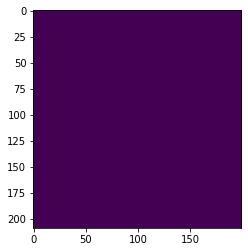

In [60]:
plt.imshow(water_numpy[0,:,:])
max(water_numpy[0,:,0])

In [ ]:
banana = banana.astype('int16')
banana

In [55]:
[len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

[]

In [77]:
tv_numpy =water_numpy
for y in range(tv_numpy.shape[1]):
    for x in range(tv_numpy.shape[2]):
        # If all the values are nan then just set output to nan and carry on",
        pixel = tv_numpy[:,y,x]

        if np.all(np.isnan(pixel)):
            consecutive_numpy[y,x] = np.nan
            continue            
            
        # Count non-nan observations
        obs = np.count_nonzero(~np.isnan(pixel))
        
        if obs == 1:
            rc = 1
        elif obs != 1:
            rc = required_consecutive
        
#         print(required_consecutive)

        # get counts of consecutive veg classifications
        counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]
#         counts = [len(list(group))]
        
#         print(counts)
        #print(max(counts))
    

        if not counts:
            consecutive_numpy[y,x] = 0
        elif max(counts) >= rc:
            consecutive_numpy[y,x] = 1
        else:
            consecutive_numpy[y,x] = 0

In [17]:
# Access individual pixel
for y in range(water_numpy.shape[1]):
    for x in range(water_numpy.shape[2]):
        pixel = water_numpy[:,y,x]

        # Change nan to '2'
        # TODO
#             if np.all(np.isnan(pixel)):
#                 consecutive_numpy[y,x] = np.nan
#                 continue    

        # Get the binary code of inundated or not
        # Convert temporal pixel array to list, convert to string, and back to integer
        value = int(''.join(str(e) for e in pixel.tolist()))

        # Assign value to consecutive numpy
        banana[y,x] = value



In [14]:
banana

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 6599, 6599, 6599],
       [   0,    0,    0, ...,  455, 6599, 6599],
       [   0,    0,    0, ...,  454, 6599, 6599]], dtype=int16)

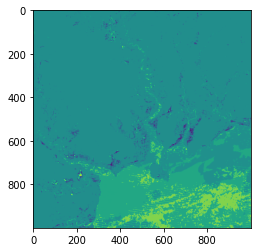

In [13]:
plt.imshow(banana)

From the above we can see that `int(''.join(str(e) for e in pixel.tolist()))` seems to work well, a 12 digit binary number representing inundation is made

### Try to implement above method into consecutive count code

In [10]:
def monthly_inundation(water_dominant,water_numpy,consecutive_numpy):
    #
    if len(water_dominant.coords['month'].values) == 12:
        print('12 months of data')

        # Access individual pixel
        for y in range(water_numpy.shape[1]):
            for x in range(water_numpy.shape[2]):
                pixel = water_numpy[:,y,x]

                # Change nan to '2'
                # TODO
    #             if np.all(np.isnan(pixel)):
    #                 consecutive_numpy[y,x] = np.nan
    #                 continue    

                # Get the binary code of inundated or not
                # Convert temporal pixel array to list, convert to string, and back to integer
                value = int(''.join(str(e) for e in pixel.tolist()))

                # Assign value to consecutive numpy
                consecutive_numpy[y,x] = value

        return consecutive_numpy
    
    else:
        consecutive_numpy[y,x] = 999999999999

This image should be the same as the one above

12 months of data


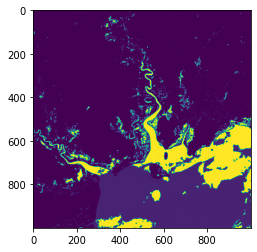

In [11]:
testrun = monthly_inundation(water_dominant,water_numpy,banana)
plt.imshow(testrun)

test_summary <xarray.DataArray (y: 1000, x: 1000)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1111111e+10,
        1.1111111e+10, 1.1111111e+10],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1111111e+11,
        1.1111111e+10, 1.1111111e+10],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1111111e+11,
        1.1111111e+10, 1.1111111e+10]], dtype=float32)
Coordinates:
    spatial_ref  int32 0
  * x            (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 250.0 150.0 50.0
  * y            (y) float64 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06


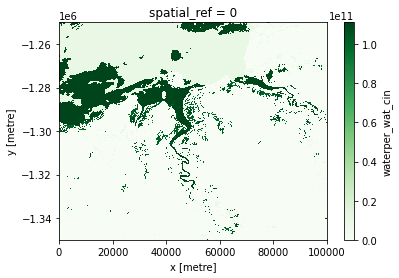

In [12]:
# using max here but not important as we just want to use shape/attributes
water_reduce = water_mask.max(dim='month')

# create new data array with sampe dimensions as original
test_summary = xr.DataArray(testrun, coords=water_reduce.coords, dims=water_reduce.dims)
print('test_summary',test_summary)

test_summary_ds = test_summary.to_dataset(name='waterper_wat_cin')
test_summary_ds.waterper_wat_cin.plot(cmap='Greens')

## Export out tiff for further investigation

In [13]:
write_geotiff('test_summary_ds.tif', test_summary_ds)

/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)
